In [25]:
import os
from typing import List

import pandas as pd
from webvtt import WebVTT

In [26]:
data_dir = './ted-talks-transcript'
ted_data_file = os.path.join(data_dir, 'ted_metadata_kaggle.csv')
captions_dir = os.path.join(data_dir, 'subtitles')
available_captions = os.listdir(captions_dir)

In [27]:
df = pd.read_csv(ted_data_file)

In [273]:
tags = set()
for t in df['tags']:
    tags.update(eval(t))

In [275]:
len(tags)

416

In [29]:
# Find videos with transctipt
df_valid = df[df['vidID_youtube'].notnull()][['name', 'vidID_youtube']]

In [30]:
def get_caption_filename(name: str, lang='en', file_format='vtt') -> str:
    filename: str = f'{name}.{lang}.{file_format}'
    path: str = os.path.join(captions_dir, name, filename)
    return path

In [31]:
def get_caption_file(name: str, lang='en', file_format='vtt') -> WebVTT:
    """Searches for caption file with a given name and return VTT instance"""
    path: str = get_caption_filename(name, lang=lang, file_format=file_format);

    if os.path.exists(path):
        return WebVTT().read(path)
    return None

In [32]:
def get_text(caption_file: WebVTT) -> str:
    if caption_file is None:
        return ''
    
    caption_list = map(lambda c: c.text, caption_file.captions)
    
    return ' '.join(caption_list)

In [33]:
def save_text(name: str) -> None:
    caption_file = get_caption_file(name)
    
    if caption_file is None:
        return None
    
    caption_list = map(lambda c: c.text + ' ', caption_file.captions)
    
    filename = caption_file.file.split('.')
    filename[-1] = 'txt'
    filename = '.'.join(filename)
    
    with open(filename, 'w') as f:
        f.writelines(caption_list)

In [34]:
# Check that all documents are stored
df_valid['filename'] = df_valid['vidID_youtube'].apply(get_caption_filename)
df_valid['exists'] = df_valid['filename'].apply(os.path.exists)
df_valid['filename'] = df_valid['vidID_youtube'].apply(get_caption_filename, file_format='txt')
df_valid[df_valid['exists'] == False].count()

name             0
vidID_youtube    0
filename         0
exists           0
dtype: int64

In [35]:
for name in df_valid['vidID_youtube']:
    save_text(name)

In [37]:
from string import punctuation

# Table to translate all punctuation into whitespace
table = str.maketrans({key: ' ' for key in list(punctuation)})

def preprocess(raw_text: str) -> str:
    """Remove all punctuation from the text"""
    raw_text = raw_text.translate(table)
    return raw_text.lower()

In [58]:
from nltk import word_tokenize, pos_tag
from nltk.stem import PorterStemmer, WordNetLemmatizer

lemmatize = True
stemmatize = False

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def tokenize(raw_text: str) -> List[str]:
    tokens = word_tokenize(raw_text)
    
    if lemmatize:
        return [lemmatizer.lemmatize(w) for w in tokens]
    return [stemmer.stem(w) for w in tokens]

In [372]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

STOP_WORDS = [stemmer.stem(w) for w in stopwords.words('english')] + [
    're go', '—', 'yeah', 'okay', 'ok', 'oh', 'ye', 'bit', 'whole', 'ever', 'bit', 're', 'go', 'c', 'isn', 'per',
    're look', 're talk', 're try', 'really want', 'say go', 'say know', 'say re', 'say well', 'th']


vectorizer = TfidfVectorizer(
    input='filename',
    tokenizer=tokenize, 
    preprocessor=preprocess,
    analyzer='word', 
    stop_words=STOP_WORDS, 
    lowercase=True, 
    ngram_range=(1, 1),
    max_df=0.5,
    min_df=0.1,
)

data = vectorizer.fit_transform(df_valid['filename'])

In [373]:
import pickle
# Dump data
pickle.dump(data, open('Tf-Idf_data.pickle', 'wb'))
pickle.dump(vectorizer, open('Tf-Idf_vectorizer.pickle', 'wb'))

In [401]:
import pickle
# Load data
data = pickle.load(open('Tf-Idf_data.pickle', 'rb'))
feature_names = pickle.load(open('Tf-Idf_feature_names.pickle', 'rb'))

In [402]:
data.shape

(2210, 916)

In [394]:
N_clusters = 10
N_components = 10

In [395]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

if N_components:
    svd = TruncatedSVD(N_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    data = lsa.fit_transform(data)

In [396]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=N_clusters, tol=1e-5)
model.fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=1e-05, verbose=0)

In [397]:
def show_clusters(model, vectorizer, svd=None):
    terms = vectorizer.get_feature_names()
    if svd is not None:
        original_space_centroids = svd.inverse_transform(model.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
    else:
        order_centroids = model.cluster_centers_.argsort()[:, ::-1]\

    for i in range(model.n_clusters):
        print("Cluster %d:" % (i + 1), end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()

show_clusters(model, vectorizer, svd)

Cluster 1: city building space street design community car project york public
Cluster 2: woman men girl child boy story man country mother young
Cluster 3: kid school child teacher student education family parent learning class
Cluster 4: love story feel man went word friend woman guy god
Cluster 5: patient cell cancer disease drug health doctor body medical medicine
Cluster 6: design technology computer data machine video information system project object
Cluster 7: brain cell body mind memory behavior pattern system animal study
Cluster 8: country government company percent money dollar state global business market
Cluster 9: music sound play hear piece voice playing eye note video
Cluster 10: water earth planet ocean animal specie plant universe sea food


In [398]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(data, model.labels_)
print("Average Silhouette Coefficient: %0.3f" % silhouette_avg)

Average Silhouette Coefficient: 0.060


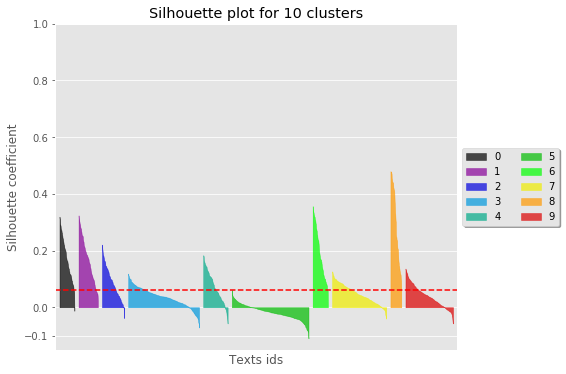

In [399]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples

def silhouette_graph(model, data, legend=False, save=False):
    plt.style.use('ggplot')
    fig = plt.figure(N_clusters, figsize=(8, 6))
    ax1 = plt.subplot(111)
    ax1.axis([0, len(model.labels_) + (model.n_clusters + 1) * 25, -0.15, 1])

    sample_silhouette_values = silhouette_samples(data, model.labels_)
    silhouette_avg = silhouette_score(data, model.labels_)

    x_left = 25
    for i in range(model.n_clusters):
        sample = sample_silhouette_values[model.labels_ == i]
        sample.sort()
        sample = sample[::-1]

        cluster_size = sample.shape[0]
        x_right = x_left + cluster_size
        color = cm.nipy_spectral(float(i) / model.n_clusters)

        ax1.fill_between(
            np.arange(x_left, x_right), 0, sample, 
            facecolor=color, edgecolor=color, alpha=0.7, label='{}'.format(i)
        )
        x_left = x_right + 25

    plt.title('Silhouette plot for {} clusters'.format(model.n_clusters))
    ax1.set_xlabel("Texts ids")
    ax1.set_ylabel("Silhouette coefficient")
    ax1.axhline(y=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    ax1.set_xticks([])
    
    if legend:
        box = ax1.get_position()
        ax1.set_position([box.x0, box.y0, box.width * 0.9, box.height])
        ax1.legend(loc='center left', fancybox=True, shadow=True, bbox_to_anchor=(1, 0.5), ncol=2)
    if save:
        plt.savefig('Silhouette plot for {} clusters.png'.format(model.n_clusters), dpi=1000)
    plt.show()

silhouette_graph(model, data, legend=True, save=True)

In [137]:
def silhouette_metric(estimator, X):
    clusters = estimator.fit_predict(X)
    score = silhouette_score(X, clusters)
    return score

In [244]:
from sklearn.model_selection import ParameterGrid
kmeans_params = ParameterGrid({'n_clusters': range(15, 31)})
svd_params = ParameterGrid({'n_components': range(100, 600, 100)})

result = [[[] for i in range(100, 600, 100)] for i in range(15, 31)]
i = 0
for k in range(15, 31):
    j=0
    model = KMeans(verbose=0, tol=1e-5).set_params(**k)
    for s in svd_params:
        svd = TruncatedSVD().set_params(**s)
        lsa = make_pipeline(svd, Normalizer(copy=False))
        X = lsa.fit_transform(data)
        
        model.fit(X)        
        result[i][j] = silhouette_score(X, model.labels_)

        j += 1
    i += 1

Doing clusters: 15, components:100
Doing clusters: 15, components:200
Doing clusters: 15, components:300
Doing clusters: 15, components:400
Doing clusters: 15, components:500
Doing clusters: 16, components:100
Doing clusters: 16, components:200
Doing clusters: 16, components:300
Doing clusters: 16, components:400
Doing clusters: 16, components:500
Doing clusters: 17, components:100
Doing clusters: 17, components:200
Doing clusters: 17, components:300
Doing clusters: 17, components:400
Doing clusters: 17, components:500
Doing clusters: 18, components:100
Doing clusters: 18, components:200
Doing clusters: 18, components:300
Doing clusters: 18, components:400
Doing clusters: 18, components:500
Doing clusters: 19, components:100
Doing clusters: 19, components:200
Doing clusters: 19, components:300
Doing clusters: 19, components:400
Doing clusters: 19, components:500
Doing clusters: 20, components:100
Doing clusters: 20, components:200
Doing clusters: 20, components:300
Doing clusters: 20, 

In [332]:
result1 = np.array(result)

In [431]:
X = np.arange(15, 31)

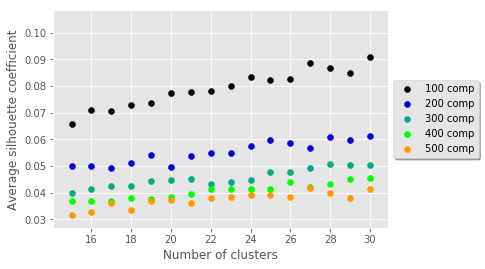

In [435]:
fig = plt.figure(5)
ax = plt.subplot(111)
for i in range(0, 5):
    color = cm.nipy_spectral(float(i) / 5)
    Y = result[:, i]
    ax.scatter(X, Y, c=color, label=f'{(i + 1) * 100} comp')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Average silhouette coefficient')
ax1.set_position([box.x0, box.y0, box.width * 0.9, box.height])
ax.legend(loc='center left', fancybox=True, shadow=True, bbox_to_anchor=(1, 0.5))
plt.savefig('Nclusters vs nComp vs avg sil.png')
plt.show()

In [308]:
lsa = make_pipeline(TruncatedSVD(100), Normalizer(copy=False))

Result = [0 for i in range(2, 200)]
i = 0
for k in range(15, 200):
    print(f"Working on {k} clusters")
    model = KMeans(n_clusters=k, verbose=0)
    X = lsa.fit_transform(data)
    model.fit(X)        
    Result[i] = silhouette_score(X, model.labels_)
    i += 1

Working on 15 clusters
Working on 16 clusters
Working on 17 clusters
Working on 18 clusters
Working on 19 clusters
Working on 20 clusters
Working on 21 clusters
Working on 22 clusters
Working on 23 clusters
Working on 24 clusters
Working on 25 clusters
Working on 26 clusters
Working on 27 clusters
Working on 28 clusters
Working on 29 clusters
Working on 30 clusters
Working on 31 clusters
Working on 32 clusters
Working on 33 clusters
Working on 34 clusters
Working on 35 clusters
Working on 36 clusters
Working on 37 clusters
Working on 38 clusters
Working on 39 clusters
Working on 40 clusters
Working on 41 clusters
Working on 42 clusters
Working on 43 clusters
Working on 44 clusters
Working on 45 clusters
Working on 46 clusters
Working on 47 clusters
Working on 48 clusters
Working on 49 clusters
Working on 50 clusters
Working on 51 clusters
Working on 52 clusters
Working on 53 clusters
Working on 54 clusters
Working on 55 clusters
Working on 56 clusters
Working on 57 clusters
Working on 

In [342]:
avgs = np.array(Result)
X = np.arange(15, 200)

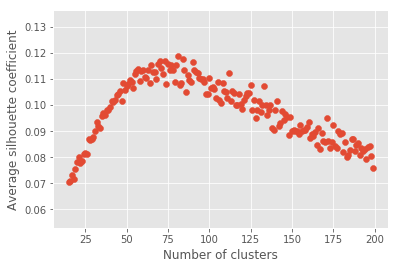

In [365]:
plt.scatter(X, avgs)
plt.xlabel('Number of clusters')
plt.ylabel('Average silhouette coefficient')
plt.savefig('Nclusters vs avg sil.png', dpi=1000)
plt.show()

In [424]:
Result_comp = [0 for i in range(100, 550, 50)]
i = 0
for k in range(100, 550, 50):
    print(f"Working on {k} components")
    lsa = make_pipeline(TruncatedSVD(k), Normalizer(copy=False))
    X = lsa.fit_transform(data)
    model = KMeans(n_clusters=10, verbose=0)
    model.fit(X)        
    Result_comp[i] = silhouette_score(X, model.labels_)
    i += 1

Working on 100 components
Working on 150 components
Working on 200 components
Working on 250 components
Working on 300 components
Working on 350 components
Working on 400 components
Working on 450 components
Working on 500 components


In [425]:
comps = np.array(Result_comp)

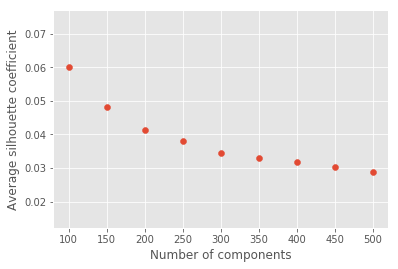

In [429]:
plt.scatter(np.arange(100, 550, 50), comps)
plt.xlabel('Number of components')
plt.ylabel('Average silhouette coefficient')
plt.savefig('Ncomponents vs avg sil.png', dpi=1000)
plt.show()